In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 80% !important; }</style>"))

In [3]:
import sys
import time
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import colors

In [4]:
myColors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
            '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
            '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
            '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
            '#307D7E', '#000000', "#DDEFFF", "#000035", "#7B4F4B", 
            "#A1C299", "#300018", "#C2FF99", "#0AA6D8", "#013349", 
            "#00846F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", 
            "#1E6E00", "#DFFB71", "#868E7E", "#513A01", "#CCAA35"]

colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [5]:
import smashpy
sf = smashpy.smashpy()

 * Initialising ...



# Loading annData object

In [8]:
obj = sc.read_h5ad('../../../../External_datasets/Healthy_foetal_organ_9933.h5ad')

In [9]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

23054 genes across 29799 cells


#### Removing general genes

In [10]:
s1 = time.time()

In [11]:
obj = sf.remove_general_genes(obj)

#### Removing house-keeping genes

http://www.housekeeping.unicamp.br/?homePageGlobal

In [12]:
obj = sf.remove_housekeepingenes(obj, path="../../data/house_keeping_genes_human_foetal_HSC.txt")
obj = sf.remove_housekeepingenes(obj, path="../../data/house_keeping_genes_human_foetal_liver.txt")

#### Removing genes expressed in less than 30% within groups

In [13]:
obj = sf.remove_features_pct(obj, group_by="organ", pct=0.3)

#### Removing genes expressed in more than 50% in a given group where genes are expressed for more 75% within a given group

In [14]:
obj = sf.remove_features_pct_2groups(obj, group_by="organ", pct1=0.75, pct2=0.5)

#### Revert PCA

In [15]:
obj = sf.scale_filter_features(obj, n_components=None, filter_expression=True)

Fraction passing PCA: 0.9160369437447523


#### DNN

In [16]:
s2 = time.time()

In [17]:
# num_classes = len(obj.obs["organ"].cat.categories)

# model = Sequential()

# model.add(Dense(1024, input_shape=(obj.X.shape[1],))) #1°layer
# model.add(BatchNormalization())
# model.add(Activation('sigmoid'))
# model.add(Dropout(0.4))


# model.add(Dense(512, input_shape=(1024,))) #2°layer
# model.add(BatchNormalization())
# model.add(Activation('sigmoid'))
# model.add(Dropout(0.1))


# model.add(Dense(128, input_shape=(512,))) #3°layer
# model.add(BatchNormalization())
# model.add(Activation('sigmoid'))

# model.add(Dense(32, input_shape=(128,))) #4°layer
# model.add(BatchNormalization())
# model.add(Activation('sigmoid'))

# model.add(Dense(num_classes, activation='softmax')) #output

# model.compile(loss=losses.categorical_crossentropy,
#               optimizer=optimizers.Adam(learning_rate=0.001, amsgrad=False),
#               metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                104768    
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0

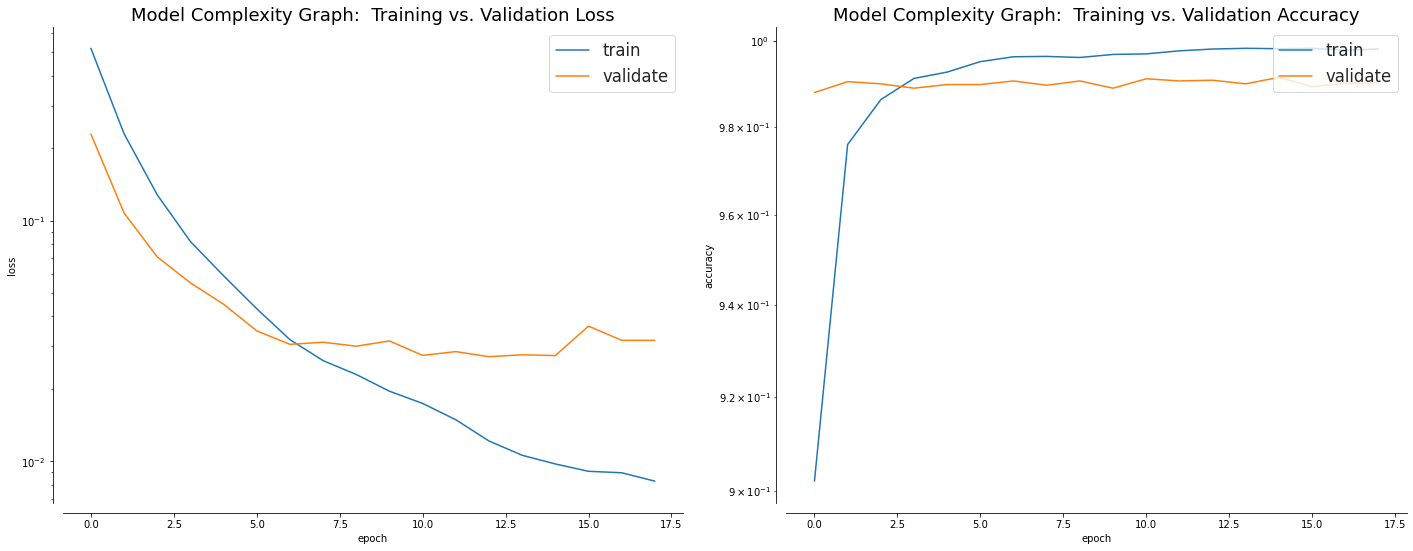

<Figure size 432x288 with 0 Axes>

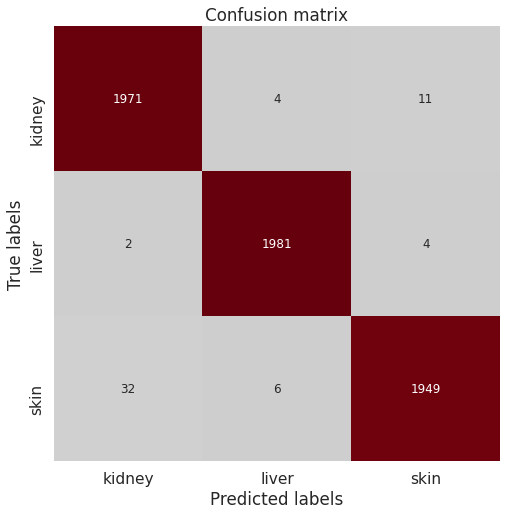

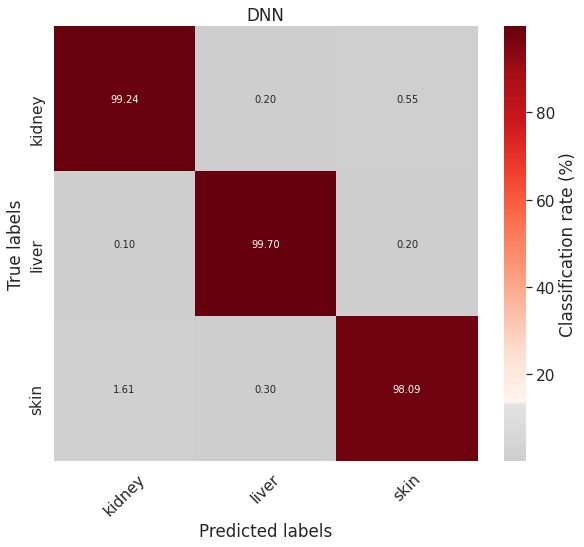

              precision    recall  f1-score   support

      kidney       0.98      0.99      0.99      1986
       liver       0.99      1.00      1.00      1987
        skin       0.99      0.98      0.99      1987

    accuracy                           0.99      5960
   macro avg       0.99      0.99      0.99      5960
weighted avg       0.99      0.99      0.99      5960

187/187 [==============================] - 0s 1ms/step - loss: 0.0272 - accuracy: 0.9908 - auc: 0.9996 - precision: 0.9909 - recall: 0.9906


In [18]:
sf.DNN(obj, group_by="organ", model=None, balance=True, verbose=True, save=True)

#### Shap value

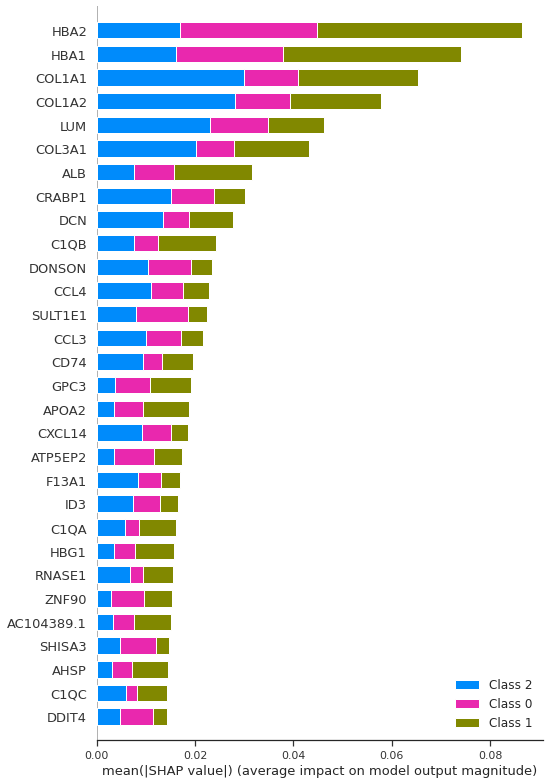

In [19]:
selectedGenes, selectedGenes_dict = sf.run_shap(obj, group_by="organ", model=None, verbose=True, pct=0.1, restrict_top=("local", 20))

In [20]:
e2 = time.time()

#### Classifiers

<Figure size 432x288 with 0 Axes>

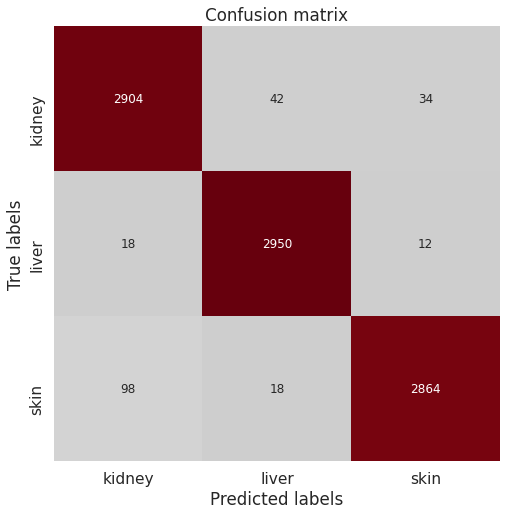

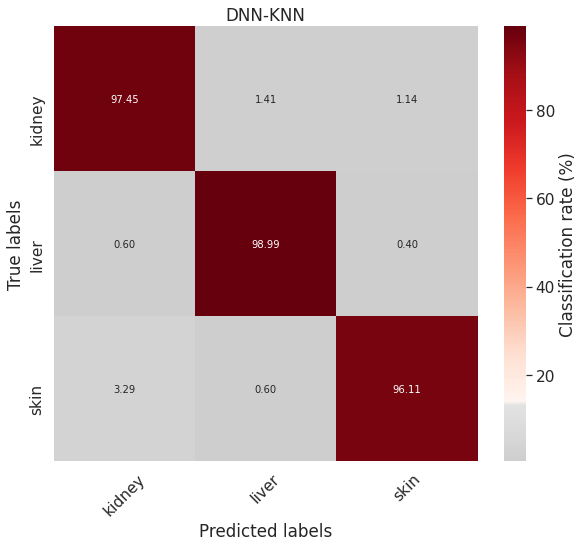

Accuracy: 0.9751677852348993: Misclassification: 0.02483221476510067
              precision    recall  f1-score   support

      kidney       0.96      0.97      0.97      2980
       liver       0.98      0.99      0.98      2980
        skin       0.98      0.96      0.97      2980

    accuracy                           0.98      8940
   macro avg       0.98      0.98      0.98      8940
weighted avg       0.98      0.98      0.98      8940



In [21]:
sf.run_classifiers(obj, group_by="organ", genes=selectedGenes, classifier="KNN", balance=True, title="DNN-KNN", save=True)

#### Sorting genes per cluster

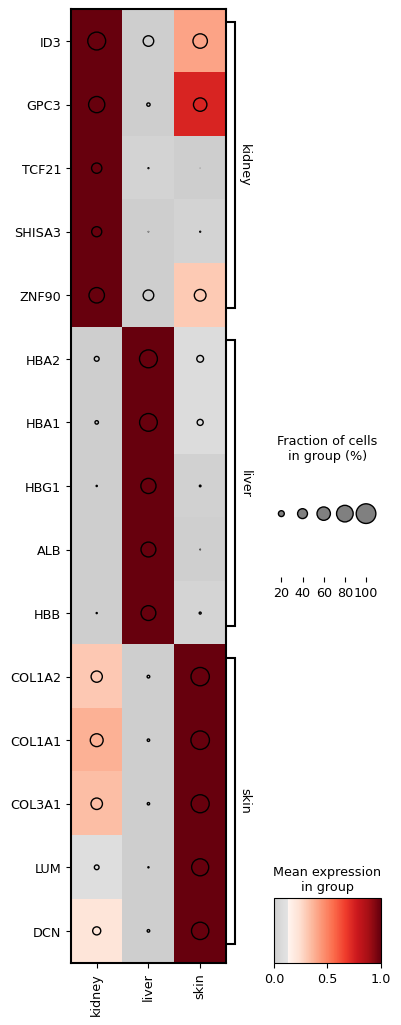

In [37]:
axs, selectedGenes_top_dict = sf.sort_and_plot(obj, selectedGenes, group_by="organ", group_by2=None, top=5, figsize=(4,12))

In [23]:
e1 = time.time()

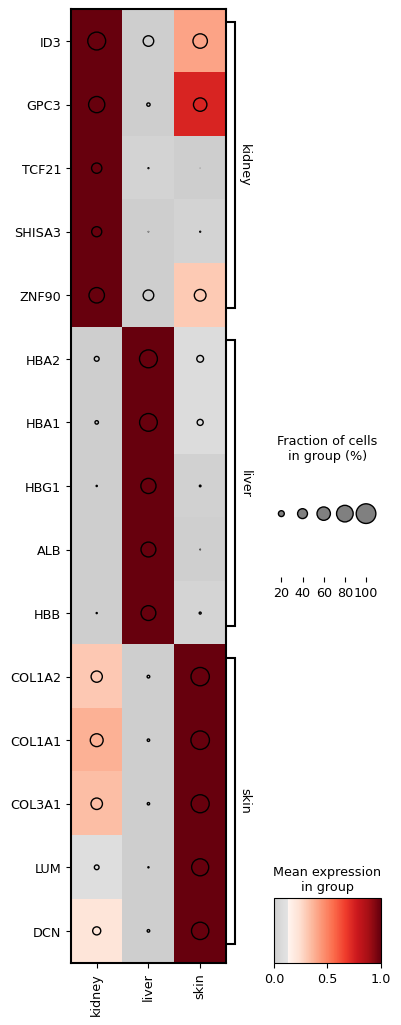

In [38]:
axs.savefig("Figures/DNN_top5_perGroup.pdf")

# Elapsed time

In [25]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

3273 genes across 29799 cells


In [26]:
print('Elapsed time (s): ', e1-s1)

Elapsed time (s):  594.7504982948303


In [27]:
print('Elapsed time (s): ', e2-s2)

Elapsed time (s):  392.35547280311584
